# Kernel Density Estimation

In [141]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.neighbors import KernelDensity
from keras.datasets import fashion_mnist
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_species_distributions

Vimos que vários algoritmos precisam estimar distribuições de probabilidades para poder realizar as estimativas. 

Um estimador de densidade (a função de probabilidades) é um algoritmo que recebe um conjunto de dados $D$-dimensional e produz uma estimativa da distribuição de probabilidade da qual esses dados são extraídos.

O algoritmo GMM faz isso representando a densidade como uma soma ponderada das distribuições gaussianas.

* KDE (Kernel Density Estimation) é um algoritmo que leva a ideia de mistura de gaussianas ao seu extremo lógico: ele usa uma mistura que consiste em um componente gaussiano *por ponto* (ou amostra), resultando em um estimador essencialmente não paramétrico de densidade.

## O problema dos Histograms

- Um estimador de densidade é um algoritmo que busca modelar a distribuição de probabilidade que gerou um conjunto de dados.

- Para dados unidimensionais, você provavelmente já está familiarizado com um estimador de densidade simples: o histograma.

- Um histograma divide os dados em *bins* (intervalos discretos), conta o número de pontos que caem em cada intervalo e, em seguida, visualiza os resultados de maneira intuitiva.

In [142]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

- Vimos anteriormente que o histograma baseado em contagem padrão pode ser criado com a função ``plt.hist()``.

- Ao especificar o parâmetro ``density`` do histograma, obtemos um histograma normalizado no qual a soma das alturas das barras é igual a 1 (tentando refletir valores de probabilidades):

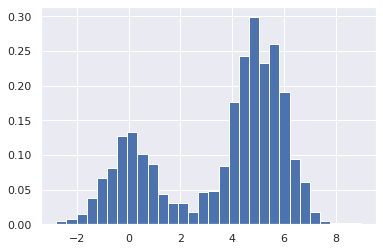

In [143]:
hist = plt.hist(x, bins=30, density = True)

A normalização ``density`` é escolhida de forma que a área total sob o histograma seja igual a 1, como podemos confirmar olhando para a saída da função de histograma:

In [144]:
density, bins, patches = hist
width =  bins[1] - bins[0]
(density * width).sum()

1.0000000000000007

- O problema de usar um histograma como um estimador de densidade é que a escolha do tamanho e localização dos *bins* pode levar a representações com características qualitativamente diferentes.

Por exemplo, se olharmos para apenas 20 pontos e escolhemos deslocar ligeiramente a posição central dos *bins* podemos obter um interpretação totalmente diferente dos dados!

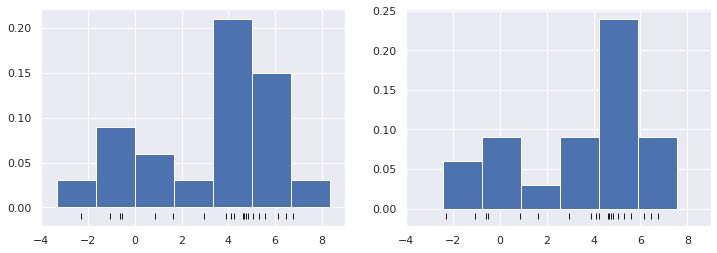

In [145]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

offset = 0.9

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(x, bins= bins, density=True)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.xlim([-4, 9])
plt.subplot(1, 2, 2)
plt.hist(x, bins= bins + offset, density=True)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.xlim([-4, 9])
plt.show()

- O histograma da direta deixa claro que se trata de uma distribuição bimodal.
- À esquerda, vemos uma distribuição unimodal com cauda longa.

Sem ver o código anterior, você provavelmente não adivinharia que esses dois histogramas foram construídos a partir dos mesmos dados: com isso em mente, como você pode confiar na intuição que os histogramas estão corretos?

E como podemos melhorar isso?

Podemos pensar em um histograma como uma pilha de blocos, em que empilhamos um bloco dentro de cada compartimento no topo de cada ponto no conjunto de dados.
Vamos ver isso diretamente:

(-0.2, 8.0)

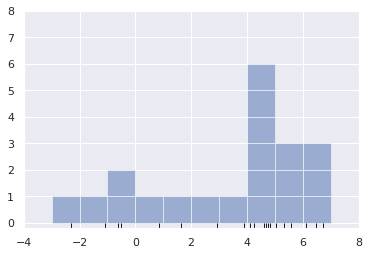

In [146]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k',
        markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1,
                                   alpha=0.5))
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

Mas e se, em vez de empilhar os blocos alinhados com os centros dos *bins*, empilhássemos os blocos alinhados com os *pontos que eles representam*?

Se fizermos isso, os blocos não ficarão alinhados, mas visualmente resulta mais interessante

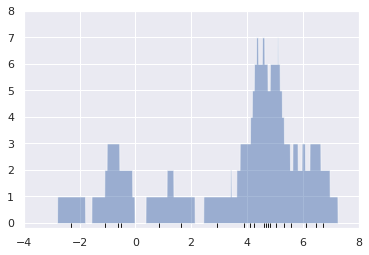

In [147]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

O resultado parece um pouco confuso, mas é um reflexo muito mais robusto das características reais dos dados.

Ainda assim, as arestas não são esteticamente agradáveis, nem refletem quaisquer propriedades verdadeiras dos dados.

Para suavizá-los, podemos decidir substituir os blocos em cada local por uma função Gaussiana.

Vamos usar uma curva normal padrão em cada ponto em vez de um bloco:

In [148]:
x.shape

(20,)

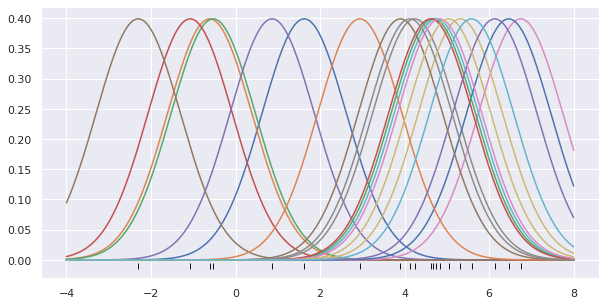

In [149]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)

plt.figure(figsize=(10,5))
for xi in x:
    plt.plot(x_d, norm(xi).pdf(x_d))
    plt.plot(xi, np.full_like(xi, -0.01), '|k', markeredgewidth=1)
plt.show()

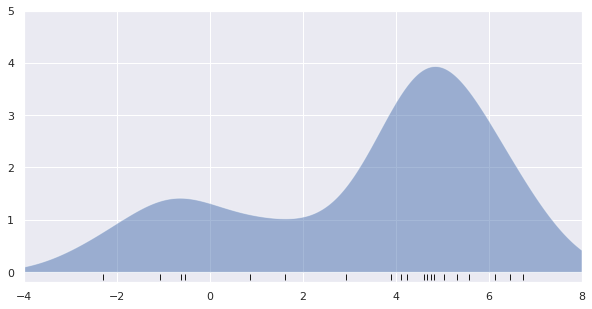

In [150]:
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.figure(figsize=(10,5))
plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

Graficando tudo junto

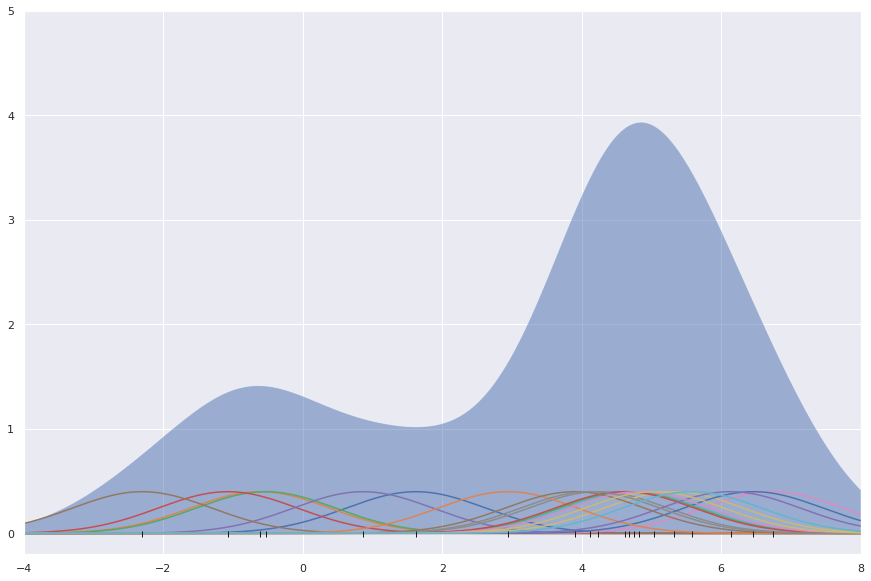

In [151]:
plt.figure(figsize=(15,10))
for xi in x:
    plt.plot(x_d, norm(xi).pdf(x_d))
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)

density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)

plt.axis([-4, 8, -0.2, 5]);

plt.show()

Este gráfico suavizado, com uma distribuição Gaussiana localizada em cada ponto dá uma ideia muito mais precisa da forma da distribuição dos dados.

Este último gráfico é um exemplo de estimativa de densidade usando **Kernel Gaussiano** em uma dimensão.

## Kernel Density Estimation (KDE) na prática

Os parâmetros ajustáveis densidade do KDE são o *kernel*, que especifica a forma da distribuição colocada em cada ponto, e a *largura de banda do kernel*, que controla o tamanho do kernel em cada ponto.


Na prática, existem muitos kernels que você pode usar, em particular, a implementação do Scikit-Learn KDE suporta seis [kernels](http://scikit-learn.org/stable/modules/density.html).


No sklearn temos ``sklearn.neighbors.KernelDensity``, que implementa o KDE em múltiplas dimensões.

A largura de banda do kernel, que é um parâmetro pode ser determinado usando as ferramentas de validação cruzada do Scikit-Learn, como veremos em breve.

Vamos primeiro mostrar um exemplo simples:

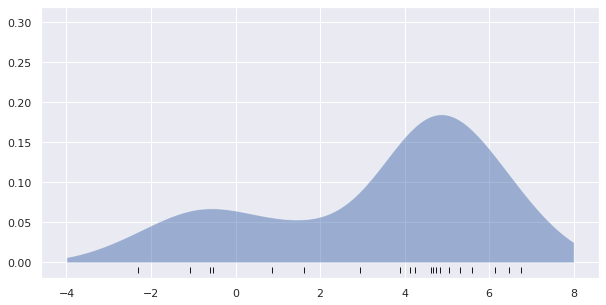

In [152]:
# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.12,  kernel='gaussian' )
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.figure(figsize=(10,5))
plt.fill_between(x_d, np.exp(logprob),
                 alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.32);

Efeito da largura de banda

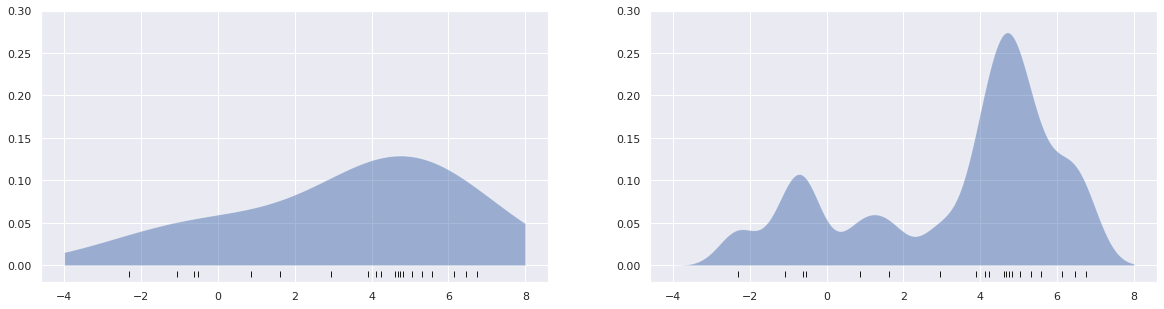

In [153]:
# instantiate and fit the KDE model
kde2 = KernelDensity(bandwidth = 2,
                     kernel='gaussian') # bandwidth controla a largura de banda do kernel
kde2.fit(x[:, None])
logprob2 = kde2.score_samples(x_d[:, None])

kde05 = KernelDensity(bandwidth= 0.5,
                      kernel='gaussian') # bandwidth controla a largura de banda do kernel
kde05.fit(x[:, None])
logprob05 = kde05.score_samples(x_d[:, None])

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.fill_between(x_d, np.exp(logprob2),
                 alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.3);
plt.subplot(1,2,2)
plt.fill_between(x_d, np.exp(logprob05),
                 alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.3);

O resultado aqui é normalizado de forma que a área sob a curva seja igual a 1.

### Selecionando a largura de banda por meio de validação cruzada

A escolha da largura de banda do kernel é extremamente importante para encontrar uma estimativa de densidade adequada: uma largura de banda muito estreita leva a uma estimativa de alta variação (ou seja, sobre-ajuste), onde a presença ou ausência de um único ponto faz uma grande diferença. 

Uma largura de banda muito ampla leva a uma estimativa de alto viés (ou seja, subajuste), onde a estrutura dos dados é apagada pelo kernel largo.

Em contextos de aprendizado de máquina, vimos que esse ajuste de hiperparâmetros geralmente é feito empiricamente por meio de uma abordagem de validação cruzada.

Com isso em mente, o estimador `` KernelDensity`` no Scikit-Learn foi projetado de forma que possa ser usado diretamente com outros métods do Scikit-Learn.

Aqui, usaremos `` GridSearchCV`` para otimizar a largura de banda para o conjunto de dados anterior.
Como estamos olhando para um conjunto de dados tão pequeno, usaremos a validação cruzada "leave-one-out", que minimiza a redução no tamanho do conjunto de treinamento para cada teste de validação cruzada:

In [154]:
bandwidths = np.linspace(0.1, 10, 200)

parms = {'bandwidth':bandwidths}

grid = GridSearchCV(KernelDensity(kernel='gaussian'), parms, cv=LeaveOneOut())

S = grid.fit(x[:, None]);

Agora podemos encontrar a escolha da largura de banda que maximiza a pontuação (que, neste caso, é o padrão para log-verossimilhança):

In [155]:
grid.cv_results_.keys()

print(grid.best_params_)
df_grid = pd.DataFrame(grid.cv_results_)
df_grid[['params', 'rank_test_score']]

{'bandwidth': 1.0949748743718595}


,params,rank_test_score
0,{'bandwidth': 0.1},200
1,{'bandwidth': 0.14974874371859298},199
2,{'bandwidth': 0.19949748743718593},198
3,{'bandwidth': 0.2492462311557789},197
4,{'bandwidth': 0.2989949748743719},175
...,...,...
195,{'bandwidth': 9.801005025125628},192
196,{'bandwidth': 9.850753768844221},193
197,{'bandwidth': 9.900502512562815},194
198,{'bandwidth': 9.950251256281406},195


{'bandwidth': 1.0949748743718595}
logprob = -2.3401496092879044


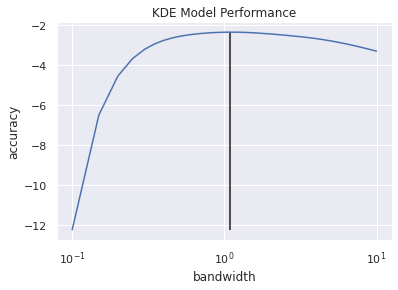

In [156]:
scores = grid.cv_results_['mean_test_score']
plt.semilogx(bandwidths, scores )
plt.vlines(grid.best_params_['bandwidth'], np.min(scores), np.max(scores) )
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('logprob =', grid.best_score_)

A largura de banda ideal está muito próxima da que usamos no gráfico de exemplo anterior, onde a largura de banda foi 1,0 (ou seja, a largura padrão de ``scipy.stats.norm``).

## Example: KDE on a Sphere

Talvez o uso mais comum do KDE seja representar graficamente distribuições de pontos.

Por exemplo, na biblioteca de visualização Seaborn, o KDE é integrado e usado automaticamente para ajudar a visualizar pontos em uma ou duas dimensões.

Aqui, veremos um uso um pouco mais sofisticado do KDE para visualização de distribuições de espécies animais.

Faremos uso de alguns dados geográficos que podem ser carregados com o Scikit-Learn: as distribuições geográficas de observações registradas de dois mamíferos sul-americanos: o *Bradypus variegatus* (a preguiça-de-garganta-marrom) e o *Microryzomys minutus* (o um pequeno rato).

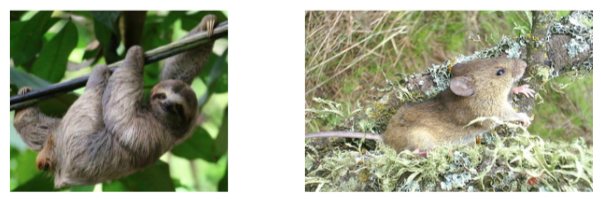

In [157]:
data = fetch_species_distributions()

# Get matrices/arrays of species IDs and locations
latlon = np.vstack([data.train['dd lat'],
                    data.train['dd long']]).T

species = np.array([d.decode('ascii').startswith('micro')
                   for d in data.train['species']], dtype='int')

In [158]:
data.train['species']

array([b'microryzomys_minutus', b'microryzomys_minutus',
       b'microryzomys_minutus', ..., b'microryzomys_minutus_9',
       b'microryzomys_minutus_9', b'microryzomys_minutus_9'], dtype='|S22')

Com esses dados carregados, podemos usar a lib Basemap para traçar as localizações observadas dessas duas espécies no mapa da América do Sul.

In [159]:
#land_reference

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.species_distributions module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


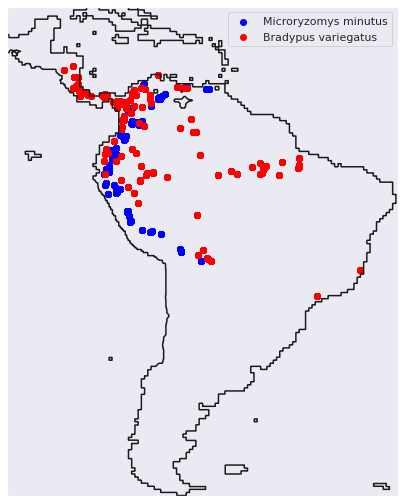

In [160]:
from sklearn.datasets.species_distributions import construct_grids

xgrid, ygrid = construct_grids(data)
X, Y = np.meshgrid(xgrid, ygrid[::-1]) # The grid in x,y coordinates
land_reference = data.coverages[6]

plt.figure(figsize=(7,9))
plt.contour(X, Y, land_reference, 
            levels=0, colors="k",
            linestyles="solid" )
plt.xticks([])
plt.yticks([])

# plot locations
plt.scatter(latlon[species == 1, 1], latlon[species == 1, 0], c='blue', cmap='rainbow', label='Microryzomys minutus')
plt.scatter(latlon[species == 0, 1], latlon[species == 0, 0], c='red', cmap='rainbow', label='Bradypus variegatus')
plt.legend()
plt.show()

## Classificação da primeira espécie

Aqui entra o conceito de One-Class

In [161]:
Xtrain = np.radians(latlon)
specie = 0

# construct a spherical kernel density estimate of the distribution
kde = KernelDensity(bandwidth=0.05, kernel='gaussian')

kde.fit(Xtrain[species == specie])

kde.score(Xtrain[species == specie])

1709.3164490049278

In [162]:
latlon_teste = np.vstack([data.test['dd lat'],
                          data.test['dd long']]).T

species_teste = np.array([d.decode('ascii').startswith('micro')
                          for d in data.test['species']], dtype='int')

Xtest = np.radians(latlon_teste)
kde.score(Xtest[species_teste == specie])

649.0805923281828

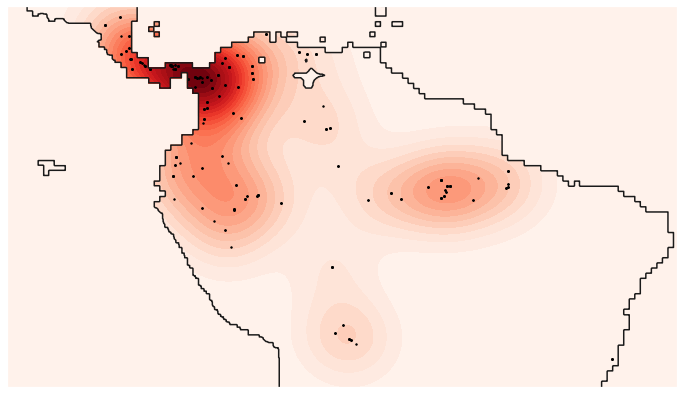

In [163]:
# evaluate only on the land: -9999 indicates ocean
land_mask = (land_reference > 0).ravel()

xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

Z = np.zeros(land_mask.shape[0])
Z[land_mask] = np.exp(kde.score_samples(xy))
Z = Z.reshape(X.shape)

# plot contours of the density
levels = np.linspace(0, Z.max(), 25)

plt.figure(figsize=(12,7))
plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
plt.contour(X, Y, land_reference, levels=0, colors="k", linestyles="solid" )
plt.scatter(latlon_teste[species_teste == specie, 1], latlon_teste[species_teste == specie, 0], c='black', cmap='rainbow', s=2)
plt.ylim([-22, 15])
plt.xticks([])
plt.yticks([])
plt.show()

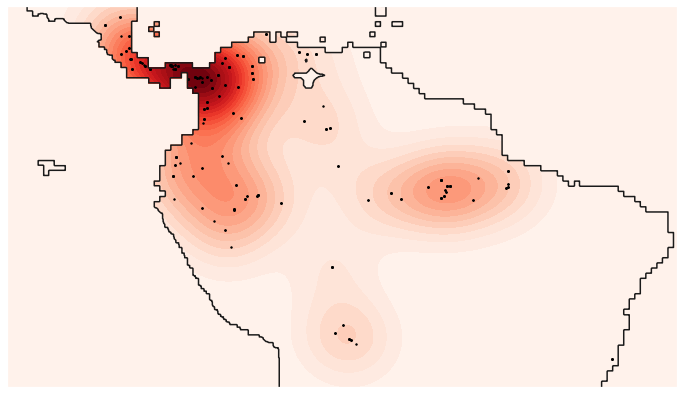

In [164]:
# evaluate only on the land: -9999 indicates ocean
land_mask = (land_reference > 0).ravel()

xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

Z = np.zeros(land_mask.shape[0])
Z[land_mask] = np.exp(kde.score_samples(xy))
Z = Z.reshape(X.shape)

# plot contours of the density
levels = np.linspace(0, Z.max(), 25)

plt.figure(figsize=(12,7))
plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
plt.contour(X, Y, land_reference, levels=0, colors="k", linestyles="solid" )
plt.scatter(latlon_teste[species_teste == specie, 1], latlon_teste[species_teste == specie, 0], c='black', cmap='rainbow', s=2)
plt.ylim([-22, 15])
plt.xticks([])
plt.yticks([])
plt.show()

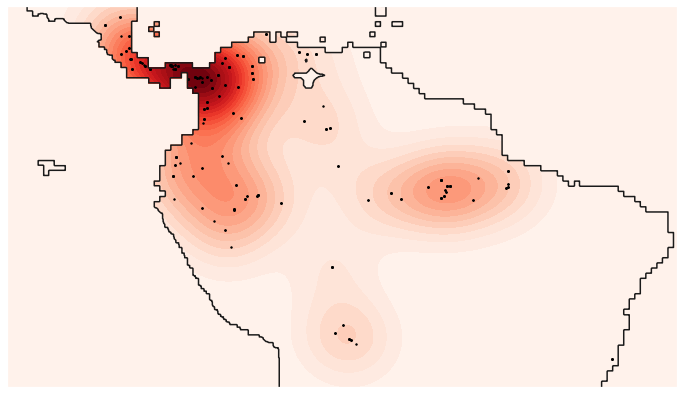

In [165]:
# evaluate only on the land: -9999 indicates ocean
land_mask = (land_reference > 0).ravel()

xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

Z = np.zeros(land_mask.shape[0])
Z[land_mask] = np.exp(kde.score_samples(xy))
Z = Z.reshape(X.shape)

# plot contours of the density
levels = np.linspace(0, Z.max(), 25)

plt.figure(figsize=(12,7))
plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
plt.contour(X, Y, land_reference, levels=0, colors="k", linestyles="solid" )
plt.scatter(latlon_teste[species_teste == specie, 1], latlon_teste[species_teste == specie, 0], c='black', cmap='rainbow', s=2)
plt.ylim([-22, 15])
plt.xticks([])
plt.yticks([])
plt.show()

# Geração de digitos com KDE

In [166]:
digits = load_digits()
data = digits.data
data.shape

(1797, 64)

In [167]:
data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [168]:
np.min(data)

0.0

In [169]:
# use grid search cross-validation to optimize the bandwidth
params = {'bandwidth': np.logspace(-1, 1, 100)}

grid = GridSearchCV(KernelDensity(kernel='gaussian'), params, cv=5)
grid.fit(data)

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

best bandwidth: 1.7073526474706913


In [170]:
grid.best_estimator_

KernelDensity(algorithm='auto', atol=0, bandwidth=1.7073526474706913,
              breadth_first=True, kernel='gaussian', leaf_size=40,
              metric='euclidean', metric_params=None, rtol=0)

In [171]:
kde = grid.best_estimator_

# geração da novas amostras
new_data = kde.sample(44, random_state=2)

# limitando os intervalos máximos e mínimos
new_data[new_data < np.min(data)] = np.min(data)
new_data[new_data > np.max(data)] = np.max(data)

In [172]:
new_data.shape

(44, 64)

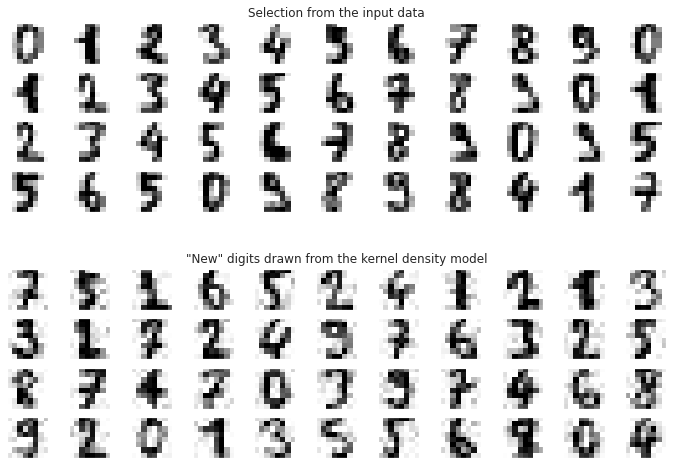

In [173]:
# turn data into a 4x11 grid
new_data = new_data.reshape((4, 11, -1))
real_data = digits.data[:44].reshape((4, 11, -1))

# plot real digits and resampled digits
fig, ax = plt.subplots(9, 11, subplot_kw=dict(xticks=[], yticks=[]), figsize=(12,8))
for j in range(11):
    ax[4, j].set_visible(False)
    for i in range(4):
        im = ax[i, j].imshow(real_data[i, j].reshape((8, 8)),
                             cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)
        im = ax[i + 5, j].imshow(new_data[i, j].reshape((8, 8)),
                                 cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)

ax[0, 5].set_title('Selection from the input data')
ax[5, 5].set_title('"New" digits drawn from the kernel density model')

plt.show()

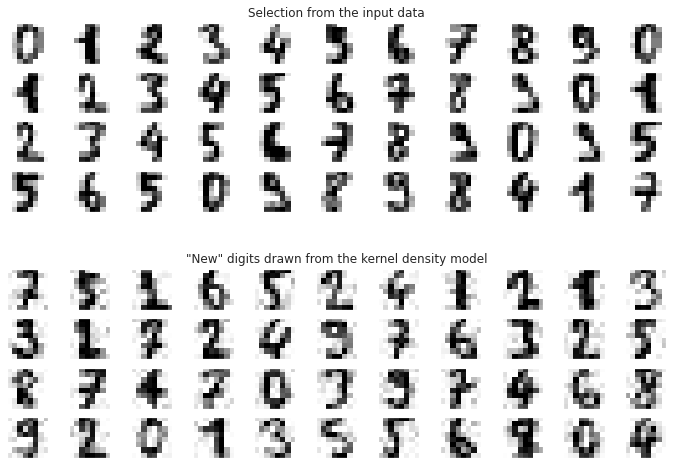

In [174]:
# turn data into a 4x11 grid
new_data = new_data.reshape((4, 11, -1))
real_data = digits.data[:44].reshape((4, 11, -1))

# plot real digits and resampled digits
fig, ax = plt.subplots(9, 11, subplot_kw=dict(xticks=[], yticks=[]), figsize=(12,8))
for j in range(11):
    ax[4, j].set_visible(False)
    for i in range(4):
        im = ax[i, j].imshow(real_data[i, j].reshape((8, 8)),
                             cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)
        im = ax[i + 5, j].imshow(new_data[i, j].reshape((8, 8)),
                                 cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)

ax[0, 5].set_title('Selection from the input data')
ax[5, 5].set_title('"New" digits drawn from the kernel density model')

plt.show()

## Geração de exemplos do Fashion MNIST

Observação 1: O carregamento dos dados pode ser realizado usando a Lib Keras.

1. Carregar o conjunto Fashion MNIST

In [175]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

2. Vetorizar as imagens

In [176]:
def show_images(X, locs, y, preds=None):
    if isinstance(locs, int):
        locs = [locs]
    fig=plt.figure(figsize=(15, 10))
    for i, val in enumerate(locs):
        fig.add_subplot(1, len(locs), i+1)
        plt.imshow(X[val].reshape((28, 28)))
    plt.show()

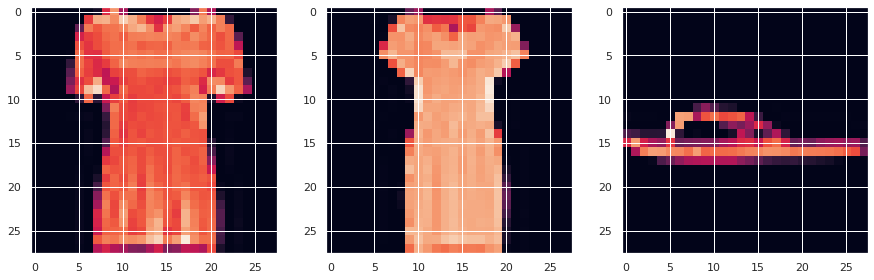

In [177]:
show_images(x_train, [10, 20, 30], y_train)

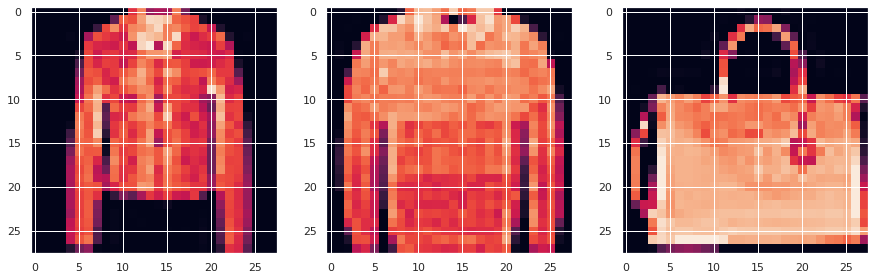

In [178]:
show_images(x_test, [10, 20, 30], y_test)

3. Escolher uma única classe

In [179]:
#Selecionando a categoria 9: ankle boot
train_filter = np.where(y_train == 9)
test_filter = np.where(y_test == 9)

X_train, Y_train = x_train[train_filter], y_train[train_filter]
X_test, Y_test = x_test[test_filter], y_test[test_filter]

4. Ajustar um KDE para essa classe

In [180]:
# construct a spherical kernel density estimate of the distribution
kde = KernelDensity(bandwidth = 0.04, kernel = 'gaussian')

X_train = X_train.reshape(X_train.shape[0], -1)
Y_train = np.array([-1,1,1])

kde.fit(X_train)
kde.score(X_train)

10766707.931495998

In [181]:
# geração da novas amostras
new_data = kde.sample(44, random_state=2)

# limitando os intervalos máximos e mínimos
new_data[new_data < np.min(X_train)] = np.min(X_train)
new_data[new_data > np.max(X_train)] = np.max(X_train)

In [182]:
new_data.shape

(44, 784)

5. Gerar novas imagens da classe
6. Plotar

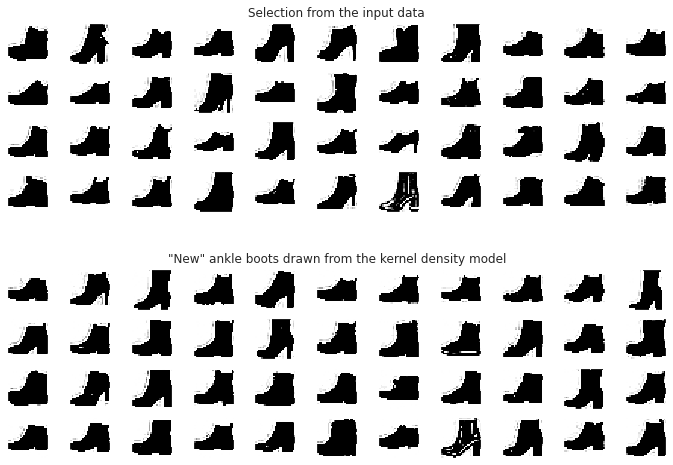

In [183]:
# turn data into a 4x11 grid
new_data = new_data.reshape((4, 11, -1))
real_data = X_train[:44].reshape((4, 11, -1))

# plot real ankle boots and resampled ankle boots
fig, ax = plt.subplots(9, 11, subplot_kw=dict(xticks=[], yticks=[]), figsize=(12,8))
for j in range(11):
    ax[4, j].set_visible(False)
    for i in range(4):
        im = ax[i, j].imshow(real_data[i, j].reshape((28, 28)),
                             cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)
        im = ax[i + 5, j].imshow(new_data[i, j].reshape((28, 28)),
                                 cmap=plt.cm.binary, interpolation='nearest')
        im.set_clim(0, 16)

ax[0, 5].set_title('Selection from the input data')
ax[5, 5].set_title('"New" ankle boots drawn from the kernel density model')

plt.show()

Observação 2: O tamanho das imagens é maior, como isso impactou o resultado? Explicar.

A diferença no tamanho das imagens possivelmente causaram erro na execução da célula de geração e plot de imagens. Duas adições foram feitas: (1) adição de *asserts* no *shape* das variáveis de treino e teste (`x_train`, `y_train`, `x_test` e `y_test`) na seção 1 e (2) mudança nos valores de *reshape* contidas nos fors na seção 5 e 6 - antes `(8,8)`.